In [21]:
import numpy as np
import pyccl as ccl
import sacc
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import scipy

# Parameters used to generate the power spectrum and baryonic boost
cosmopars = {
    'omega_cold'    :  0.31,
    'omega_baryon'  :  0.045,
    'sigma8_cold'   :  0.82,
    'ns'            :  0.965,
    'hubble'        :  0.7,
    'neutrino_mass' :  0.06,
    'w0'            : -1,
    'wa'            :  0,
    'M_c'           :  13.58,
    'eta'           : -0.27,
    'beta'          : -0.33,
    'M1_z0_cen'     :  12.04,
    'theta_out'     :  0.25,
    'theta_inn'     : -0.86,
    'M_inn'         :  13.4
}

cosmopars['omega_matter'] = cosmopars['omega_cold'] + cosmopars['neutrino_mass'] / 93.14 / cosmopars['hubble']**2
cosmopars['A_s'] = 1.8753844640255685e-09
cosmopars['sigma8_tot'] = 0.8163992592396454

# Initiate CCL Cosmology
cosmo = ccl.Cosmology(Omega_c=cosmopars['omega_cold'] - cosmopars['omega_baryon'], Omega_b=cosmopars['omega_baryon'],
                      h=cosmopars['hubble'], sigma8=cosmopars['sigma8_tot'], n_s=cosmopars['ns'], m_nu=cosmopars['neutrino_mass'])
ccl.sigma8(cosmo)

# Load the power spectrum
pkfile = np.load('./BlindCarlosPk.npz')

def get_mock_data(pk):
    # Noise 
    # sigma_e = 0.28 as in (Hilbert et al. 2017; Troxel et al. 2018)
    # number density = 26.6 gal /arcmin^2 as in (SRD, (The LSST Dark Energy Science Collaboration et al. 2018))
    nl = 0.28**2 / (26.5 * (180*60/np.pi)**2)

    # Observed sky fraction
    fsky = 0.4

    # Define binning
    ells_nobin = np.arange(3*4096)
    bpw_edges = np.array([0, 30, 60, 90, 120, 150, 180, 210, 240, 272, 309, 351, 398, 452, 513,
                          582, 661, 750, 852, 967, 1098, 1247, 1416, 1608, 1826, 2073, 2354, 2673,
                          3035, 3446, 3914, 4444, 5047, 5731, 6508, 7390, 8392, 9529, 10821, 12288])
    ells_eff = (bpw_edges[:-1] + bpw_edges[1:] - 1) / 2
    dl = bpw_edges[1:] - bpw_edges[:-1]

    ws_bpw = np.zeros((ells_eff.size, ells_nobin.size))
    for i in range(bpw_edges.size - 1):
        ws_bpw[i, bpw_edges[i]:bpw_edges[i+1]] = 1 / dl[i]
    nmodes = fsky*(2*ells_eff + 1)*dl

    # Read the redshift distributions
    dndz = np.load('./dNdzs_5src_6lens.npz')

    # Generate the angular power spectra
    tracer_names = [f'LSST__{i}' for i in range(5)]

    # Instatiate the ccl tracers
    ccl_tracers = {}
    z = np.linspace(0, 4, 100)

    for i, trn in enumerate(tracer_names):
        ccl_tracers[trn] = ccl.WeakLensingTracer(cosmo, dndz=(dndz['z_sh'], dndz['dNdz_sh'][:, i]),
                                                 has_shear=True, ia_bias=None)

    # Compute the angular power spectrum
    clmock = {}
    ixs = {}
    ixcounter = np.arange(ells_eff.size)
    for i, tr1 in enumerate(tracer_names):
        for j, tr2 in enumerate(tracer_names[i:], i):
            trs = (tr1, tr2)
            cl = ccl.angular_cl(cosmo, ccl_tracers[trs[0]], ccl_tracers[trs[1]], ells_nobin, p_of_k_a=pk)
            clbin = ws_bpw.dot(cl)
            clfinal = clbin  # No multiplicative biases
            clmock[trs] = clfinal
            ixs[trs] = ixcounter.copy()
            ixcounter += ells_eff.size

    # Compute covariance matrix using the Knox formula
    trcomb = list(clmock.keys())
    ncell = ells_eff.size * len(trcomb)
    cov = np.zeros((ncell, ncell))
    for i, trs1 in enumerate(trcomb):
        for trs2 in trcomb[i:]: 
            ix1 = ixs[trs1]
            ix2 = ixs[trs2]

            if (trs1[0], trs2[0]) in clmock:
                cli1j1 = clmock[(trs1[0], trs2[0])]
            else:
                cli1j1 = clmock[(trs2[0], trs1[0])]

            if (trs1[1], trs2[1]) in clmock:
                cli2j2 = clmock[(trs1[1], trs2[1])]
            else:
                cli2j2 = clmock[(trs2[1], trs1[1])]

            if (trs1[0], trs2[1]) in clmock:
                cli1j2 = clmock[(trs1[0], trs2[1])]
            else:
                cli1j2 = clmock[(trs2[1], trs1[0])]

            if (trs1[1], trs2[0]) in clmock:
                cli2j1 = clmock[(trs1[1], trs2[0])]
            else:
                cli2j1 = clmock[(trs2[0], trs1[1])]

            if trs1[0] == trs2[0]:
                cli1j1 = cli1j1 + nl
            if trs1[1] == trs2[1]:
                cli2j2 = cli2j2 + nl
            if trs1[0] == trs2[1]:
                cli1j2 = cli1j2 + nl
            if trs1[1] == trs2[0]:
                cli2j1 = cli2j1 + nl

            covij = np.diag((cli1j1*cli2j2 + cli1j2*cli2j1)/nmodes)

            cov[np.ix_(ix1, ix2)] = covij
            cov[np.ix_(ix2, ix1)] = covij.T

    # Create sacc file with these clmocks
    smock_nn = sacc.Sacc()
    wins = sacc.BandpowerWindow(ells_nobin, ws_bpw.T)
    for i, trn in enumerate(tracer_names):
        smock_nn.add_tracer('NZ', trn, quantity='galaxy_shear', spin=2,
                            z=dndz['z_sh'], nz=dndz['dNdz_sh'][:, i])

    for tr1, tr2 in trcomb:
        cli = clmock[(tr1, tr2)]
        smock_nn.add_ell_cl('cl_ee', tr1, tr2, ells_eff, cli, window=wins)
    smock_nn.add_covariance(cov)

    # Create sacc file with these clmocks
    smock = smock_nn.copy()
    smock.mean = np.random.multivariate_normal(mean=smock_nn.mean, cov=smock_nn.covariance.covmat)
    return smock_nn, smock

/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons/lib/python3.9/site-packages/pyccl/core.py:745: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


In [35]:
pk = ccl.Pk2D(a_arr=pkfile['expfactors'], lk_arr=np.log(pkfile['k [1/Mpc]']), pk_arr=np.log(pkfile['Pk with baryons [Mpc]^3']), is_logp=True)
smock_nn, smock = get_mock_data(pk)
smock_nn.save_fits('./lsst_mockEuclidEmulator2_BAHAMAS_noiseless.fits', overwrite=True)
smock.save_fits('./lsst_mockEuclidEmulator2_BAHAMAS.fits', overwrite=True)

pk_gro = ccl.Pk2D(a_arr=pkfile['expfactors'], lk_arr=np.log(pkfile['k [1/Mpc]']), pk_arr=np.log(pkfile['Pk GrO [Mpc]^3']), is_logp=True)
smock_gro_nn, smock_gro = get_mock_data(pk_gro)

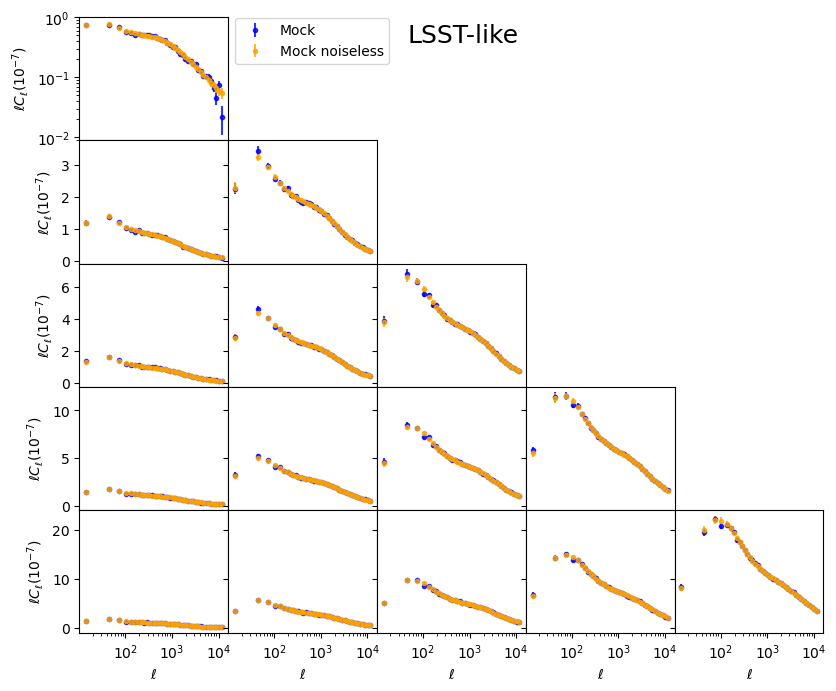

In [33]:
survey = 'LSST'
nbin = 5


f, ax = plt.subplots(nbin, nbin, figsize=(9.6, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in smock.get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Mock
    ell, cl, cov, ind = smock.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='blue', label='Mock', alpha=0.8)   
    
    # Mock noiseless
    ell, cl, cov, ind = smock_nn.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='orange', label='Mock noiseless', alpha=0.8)

    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")
    ax[0, i].set_yscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}-like', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))


plt.show()
plt.close()

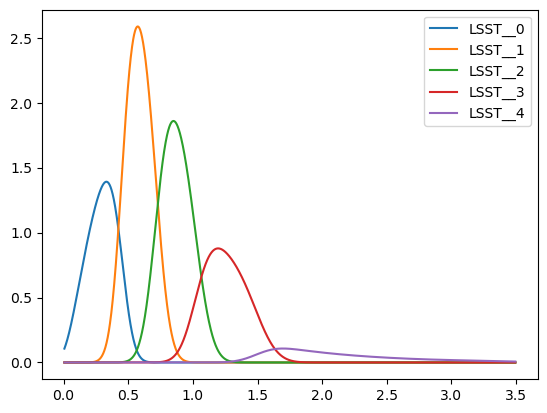

In [36]:
f, ax = plt.subplots()
for trn, tr in smock_nn.tracers.items():
    ax.plot(tr.z, tr.nz, label=trn)
    
ax.legend()
plt.show()
plt.close()

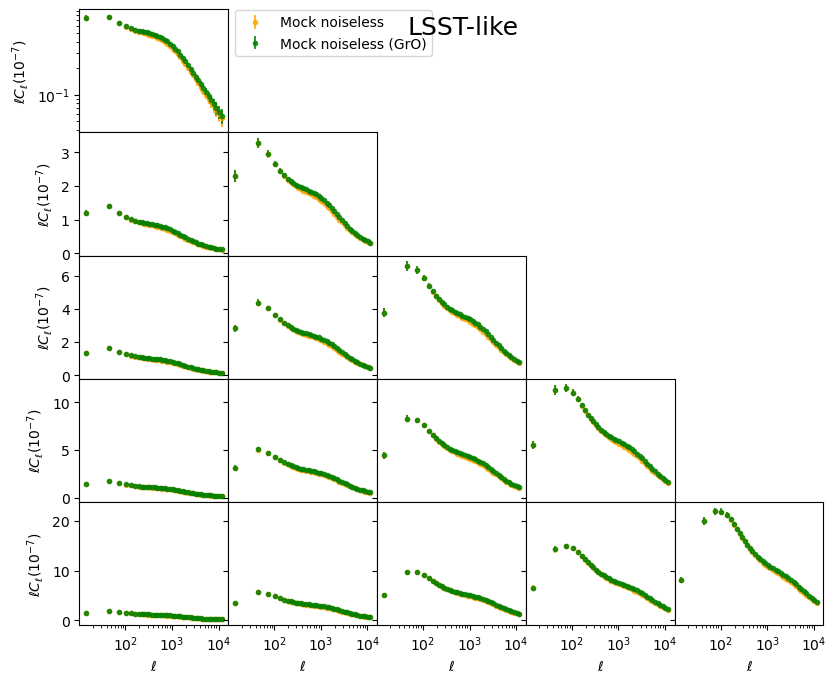

In [34]:
survey = 'LSST'
nbin = 5


f, ax = plt.subplots(nbin, nbin, figsize=(9.6, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in smock.get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])   
    
    # Mock noiseless
    ell, cl, cov, ind = smock_nn.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='orange', label='Mock noiseless', alpha=0.8)
    
    # Mock noiseless
    ell, cl, cov, ind = smock_gro_nn.get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color='green', label='Mock noiseless (GrO)', alpha=0.8)

    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")
    ax[0, i].set_yscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}-like', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))


plt.show()
plt.close()